In [72]:
%matplotlib inline
import sys, os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['THEANO_FLAGS'] = 'device=gpu'
sys.path.append(os.getcwd()+"/..")

from tasks import check as load_filename
from scripts.imgtovideo import imgs_to_video


import matplotlib.pyplot as plt
import numpy as np

import theano
import theano.tensor as T

from lasagne import layers as L

from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images

from IPython.display import HTML

import pandas as pd

from tqdm import tqdm

import base64
import json

from skimage.io import imread
from skimage.transform import resize

def load_model(filename, **kw):

    model = load_filename(
        what="notebook", 
        filename=filename, 
        dataset='digits',
        **kw
    )
    return model

def build_brush_func(layers):
    bias = layers['bias'].b.get_value()
    X = T.tensor4()
    fn = theano.function(
        [X], 
        T.nnet.sigmoid(L.get_output(layers['brush'], X) + bias)
    )
    return fn

def build_encode_func(layers):
    w = layers['output'].output_shape[2]
    X = T.tensor4()
    fn = theano.function(
        [X], 
        T.nnet.sigmoid(L.get_output(layers['coord'], X)[:, :, 0:2]) * w
    )
    return fn

def to_grid_of_images(seq_imgs):
    y = seq_imgs
    imgs = []
    for t in range(y.shape[1]):
        yy = y[:, t]
        yy = yy[:, :, :, None] * np.ones((1, 1, 1, 3))
        img = dispims_color(yy, border=0)
        imgs.append(img)
    return imgs

def seq_to_video(seq, filename='out.mp4', verbose=1, framerate=8, rate=8):
    # shape of seq should be : (examples, time, w, h) or (examples, time, 1, w, h)
    if len(seq.shape) == 5:
        seq = seq[:, :, 0, :, :]
    seq = to_grid_of_images(seq)
    seq = [np.zeros_like(seq[0])] + seq
    if os.path.exists(filename):
        os.remove(filename)
    imgs_to_video(seq, out=filename, verbose=verbose, framerate=framerate, rate=rate)

def embed_video(filename):
    video = open(filename, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii')))
def disp_grid(imgs):
    # shape of imgs should be : (examples, color, w, h)
    out = dispims_color(imgs.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)))
    return out

## Load model and build functions

In [114]:
# some selected models :
# 1) ../training/brush7/model.pkl
# 2) ../jobs/results/df2631577eaf38b002c6c0ae6f1937e1/model.pkl 
# 3) ../jobs/results/68fa4141b9f970f6bde95da53b8e54fe/model.pkl 
# 4) ../jobs/results/88b68a0c06bfb0a837cf7c0b77fe7eb9/model.pkl 
# 5) ../jobs/results/9c70a6ee9340c85b398a31f7d16be962/model.pkl
# 6) ../jobs/results/bc8b5c4156561f4f09685874d52ba20e/model.pkl
# 7) ../jobs/results/a50c86acf5a2875dda6e1ac5b8d462c1/model.pklf
model, data, layers, w, h, c = load_model('../jobs/results/68fa4141b9f970f6bde95da53b8e54fe/model.pkl')

Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 9999999999, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 800, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': 'adadelta'}


In [151]:
print(json.dumps(model.hypers['model_params'], indent=4))

{
    "normalize": "sigmoid", 
    "nb_recurrent_layers": 3, 
    "nonlin": "rectify", 
    "nb_fc_units": [
        1400, 
        1400
    ], 
    "nb_recurrent_units": [
        100, 
        100, 
        300
    ], 
    "reduce": "sum", 
    "stride": false, 
    "nb_fc_layers": 2, 
    "n_steps": 61, 
    "sigma": null, 
    "patch_size": 4
}


In [117]:
encode = build_encode_func(layers) # transforms image to sequence of coordinates

In [118]:
brush = build_brush_func(layers) # transforms an image to sequence of images

In [119]:
reconstruct = model.reconstruct # reconstructs an image

## Get coords from images

In [120]:
encode(model.preprocess(data.X[0:10])).shape # (examples, time, 2)

(10, 61, 2)

## Create a video

In [121]:
imgs = brush(model.preprocess(data.X[0:16*16])) # (examples, time, w, h)
print(imgs.shape)
seq_to_video(imgs, 'seq.mp4')
embed_video('seq.mp4')

(128, 61, 28, 28)


/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:159: UserWarning: /tmp/img_to_videoriy1Lf/img00000000.png is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)


ffmpeg -framerate 8 -i img%08d.png -c:v libx264 -r 8 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/seq.mp4


## Reconstruct

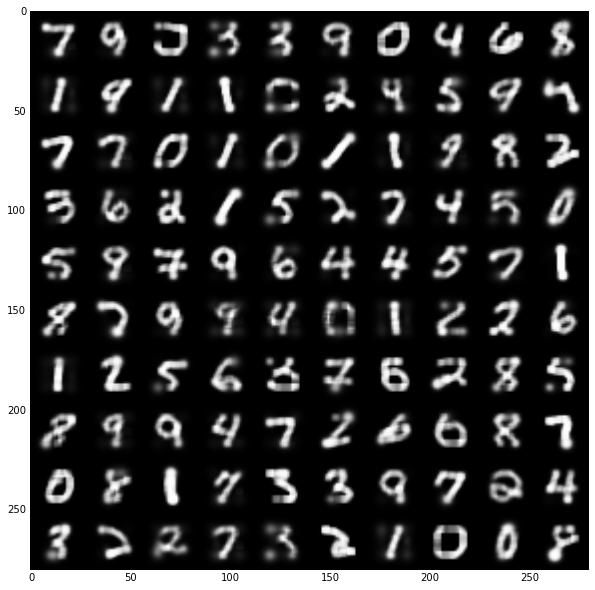

In [122]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(disp_grid(reconstruct(model.preprocess(data.X[0:100]))), cmap='gray')

## iterative refinement

In [123]:
nb_iter = 100
nb_examples = 100

np.random.seed(2)

imgs = np.empty((nb_examples, nb_iter + 1, 1, w, h)) # 1 = color channel
imgs = imgs.astype(np.float32)

imgs[:, 0] = np.random.uniform(size=(nb_examples, 1, w, h))
for i in tqdm(range(1, nb_iter + 1)):
    imgs[:, i] = reconstruct(imgs[:, i - 1])
    imgs[:, i] = imgs[:, i] > 0.5 # binarize

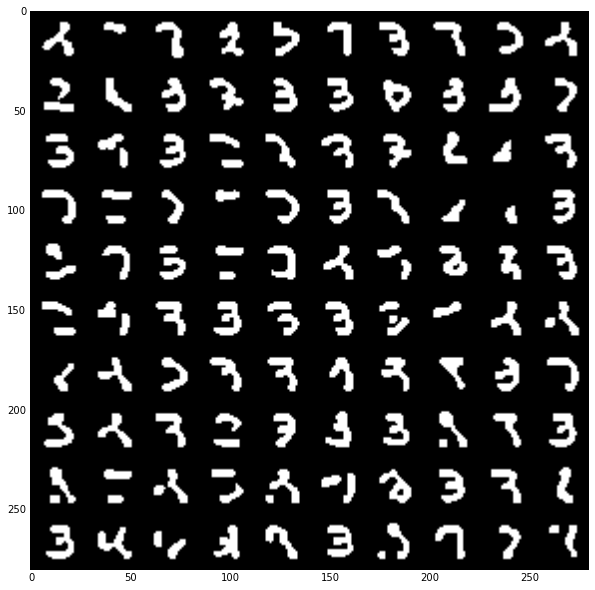

In [124]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(disp_grid(imgs[:, -1])) # display last time step

In [125]:
seq_to_video(imgs, 'ir.mp4')
embed_video('ir.mp4')

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:159: UserWarning: /tmp/img_to_video2B1iov/img00000000.png is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)


ffmpeg -framerate 8 -i img%08d.png -c:v libx264 -r 8 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/ir.mp4


## Feeding a new image

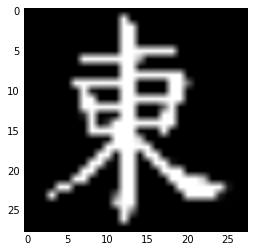

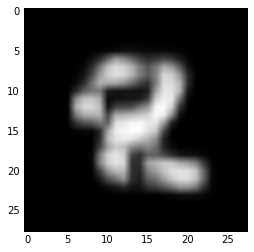

In [158]:
img = imread('4Tbx4rALc.jpeg')
img = img[:, :, 0]
img = resize(img, (28, 28), preserve_range=True)

img = img.astype(np.float32)
img /= 255.
img = 1 - img

dt = np.empty((1, 1, w, h), dtype='float32') # (nb_examples, color, w, h)
dt[0, 0] = img
plt.imshow(dt[0, 0], cmap='gray')
plt.show()
plt.imshow(reconstruct(dt)[0, 0], cmap='gray')
plt.show()